# Анализ бизнес-показателей на примере данных из Яндекс.Афиши

У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

*Цель работы* - помочь маркетологам оптимизировать маркетинговые затраты.

Мы изучим:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

Работать будем с выгрузками данных visits_log.csv, orders_log.csv, costs.csv.

# Содержание работы:
1. [Шаг 1. Изучение данных и предобработка](#p1)
2. [Шаг 2. Предобработка данных](#p2)   
    2.1 [Продукт](#p2_1)  
    - [количество уникальных пользователей в день](#p2_1_1) 
    - [среднее количество сессий в день и среднее время сессии ](#p2_1_2)
    - [как часто люди возвращаются на сайт (Retention Rate)](#p2_1_3)
    
   2.2 [Продажи](#p2_2) 
     - [когда люди начинают покупать](#p2_2_1) 
     - [cколько раз покупают за период](#p2_2_2)
     - [средний чек](#p2_2_3) 
     - [сколько денег приносят? (LTV) ](#p2_2_4) 

   2.3 [Маркетинг](#p2_3) 
     - [потрачено](#p2_3_1) 
     - [сколько стоило привлечение одного покупателя из каждого источника](#p2_3_2) 
     - [на сколько окупились расходы? (ROI)](#p2_3_3) 
     - [метрики в разрезе источников и устройств ](#p2_3_4) 
     

3. [Шаг 3. Вывод и рекомендации](#p3)     



<b> Шаг 1. Изучение данных и предобработка <a name="p1"></a>

Подгрузим библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt

Прочитаем файлы с данными.

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Изменим названия столбцов.

In [3]:
visits.columns = visits.columns.str.lower()
visits.set_axis(['device','end_ts','source_id','start_ts','uid'],axis = 'columns',inplace = True)

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Пустых значений нет. Преобразуем типы дат.

In [5]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y.%m.%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y.%m.%d %H:%M:%S')

In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [7]:
visits.describe()

,source_id,uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


In [8]:
visits.duplicated().mean()

0.0

Дубликатов нет.

Рассмотрим данные по заказам.

In [9]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


Изменим названия столбцов.  Преобразуем типы дат.

In [10]:
orders.set_axis(['buy_ts','revenue','uid'],axis = 'columns',inplace = True)

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [12]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y.%m.%d %H:%M:%S')

In [13]:
orders.describe()

,revenue,uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


In [14]:
orders.duplicated().mean()

0.0

Рассмотрим данные по тратам.

In [15]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [16]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


 Преобразуем типы дат.

In [17]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y.%m.%d')

In [18]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


In [19]:
costs.duplicated().mean()

0.0

Дубликатов нет.

<b> Шаг 2. Построение отчётов и просчет метрики <a name="p2"></a>

<b> 2.1 Продукт <a name="p2_1"></a>

<b> Найдем количество уникальных пользователей в день, неделю, месяц по выборке. <a name="p2_1_1"></a>

In [20]:
visits['day']  = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
visits.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017


Рассчитаем DAU, WAU и MAU.

In [21]:
dau = visits.groupby('day').agg({'uid': 'nunique'}).mean()
wau = visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()
mau = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()

print('Среднее количество уникальных пользователей в день:',dau)
print('Среднее количество уникальных пользователей в неделю:',wau)
print('Среднее количество уникальных пользователей в месяц:',mau)

Среднее количество уникальных пользователей в день: uid    907.991758
dtype: float64
Среднее количество уникальных пользователей в неделю: uid    5716.245283
dtype: float64
Среднее количество уникальных пользователей в месяц: uid    23228.416667
dtype: float64


Построим распределение уникальных пользователей по месяцам.

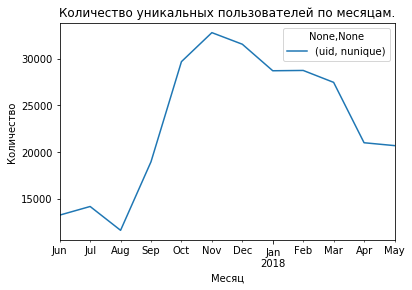

In [22]:
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
users_count = visits.groupby('visit_month').agg({'uid': ['nunique']})
users_count.plot();
plt.title('Количество уникальных пользователей по месяцам.')
plt.xlabel('Месяц');
plt.ylabel('Количество');

На графике отчетливо видны моменты проседания активности пользователей и их пики. Летом интерес пользователей к событиям культуры проседает. Осень, зима, весна - значительно больше интерисующихся. 

Страшно представить, каким был бы этот график в 2020 году, хм.

<b> Найдем среднее количество сессий в день и среднее время сессии <a name="p2_1_2"></a>

In [23]:
session_count = visits.groupby('day')['start_ts'].count().mean()
session_time = (visits['end_ts'] - visits['start_ts']).mean()
print('Cреднее количество сессий в день',session_count)
print('Cреднее время сессии',session_time)

Cреднее количество сессий в день 987.3626373626373
Cреднее время сессии 0 days 00:10:43.025687


В среднем на сайт в день заходят 987 раз. Среднее время сессии 10,5 минут.

<b> Чтобы определить как часто люди возвращаются на сайт рассчитаем Retention Rate <a name="p2_1_3"></a>

Найдем время первой сессии пользователя.

In [24]:
visits['day'] = pd.to_datetime(visits['day'])
first_session_date = visits.groupby('uid')['day'].min()
first_session_date.name = 'first_session_date'

Сджойним его у таблице визитов.

In [25]:
visits = visits.join(first_session_date,on='uid')

Рассчитаем метрику возврата пользователй по неделям. Проведем когортный анализ. Каждый месяц - новая когорта. 

Получим день начала недели, за которую произошло событие, он станет идентификатором недели. Вычтем из даты порядковый номер дня.

In [26]:
visits['activity_week'] = pd.to_datetime(visits['day'], unit='d') - pd.to_timedelta(visits['day'].dt.dayofweek, unit='d')
visits['first_activity_week'] = pd.to_datetime(visits['first_session_date'], unit='d') - pd.to_timedelta(visits['first_session_date'].dt.dayofweek, unit='d') 
visits['activity_month'] = visits['visit_month']
visits['first_activity_month'] = visits['first_session_date'].astype('datetime64[M]')

Найдем жизненный цикл пользователя.

In [27]:
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') 

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни».

In [28]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
#cohorts = cohorts.query('cohort_lifetime <= 10 and first_activity_week < "2018-01-01"')

Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц.

In [29]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]

Объединим данные по когортам с исходным количеством пользователей в когорте:

In [30]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

Наконец, рассчитаем Retention Rate. Разделим количество активных пользователей за каждый месяц на исходное число пользователей в когорте.

In [31]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

Построим сводную таблицу и создадим тепловую карту.

In [32]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

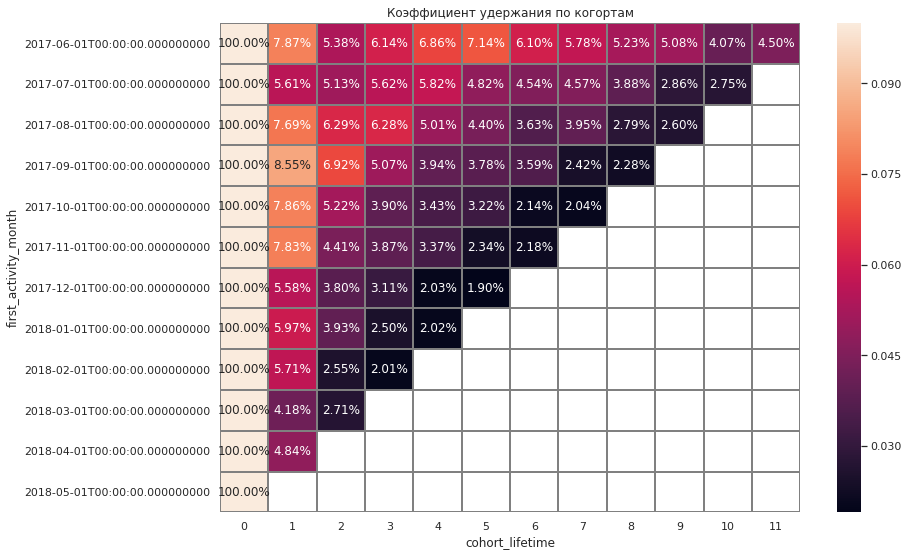

In [33]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Коэффициент удержания по когортам')
sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='gray', vmax=0.1);

Самый высокий Retention Rate первой недели отмечен в первой когорте пользователей - 9,2 %. Да и в целом эта когорта выделяется от остальных. Может в конце мая была запущена активная рекламная компания с плюшками?

В дальнейшем он варьируется по когортам с течением времени от 2,7 до 5,7 % и убывает начиная со 2 недели.
В целом, можно отметить очень низкий коэффициент возврата пользователей и низкий коэффицент их удержания.

Долю вернувшихся пользователей можно рассчитать и проще.

Отберем пользователей, совершивших 2 и более сессии

In [34]:
repeat = visits.groupby(['uid'])['start_ts'].count().reset_index()
repeat = repeat.query('start_ts > 1')

Поделим количество вернувшихся на общее количество уникальных пользователей.

In [35]:
repeat['start_ts'].count() / len(visits['uid'].unique()) * 100

22.84622363248294

Таким образом только 22,8 % пользователей возвращаяются на сайт. Есть над чем работать.

------------------------------------------------------------------------------------------
<b> 2.2 Продажи <a name="p2_2"></a>

<b> Когда люди начинают покупать? <a name="p2_2_1"></a>

In [36]:
orders['day']  = orders['buy_ts'].dt.date
orders['week'] = orders['buy_ts'].dt.week
orders['month'] = orders['buy_ts'].dt.month
orders['year'] = orders['buy_ts'].dt.year

orders.head()

,buy_ts,revenue,uid,day,week,month,year
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017


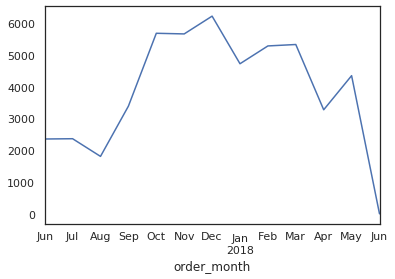

In [37]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.groupby(['order_month'])['buy_ts'].count().plot(y='buy_ts');

Видим, что покупки на сайте проседают летом и достигают пиковых значений к новому году и весной. Думаю от части это можно связать с подготовкой к праздникам и поиском отличных подарков.

Посчитаем отдельно расклад по новым покупателям, чтобы найти среднее время покупки с момента первого посещения.

In [38]:
first_orders2 = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders2.columns = ['uid', 'first_order_day']
visit_first_buy = pd.merge(visits,first_orders2, on='uid') 

In [39]:
visit_first_buy2 = orders.groupby('uid').agg({'buy_ts': 'min'})\
            .rename(columns={'buy_ts': 'first_buy_ts'})\
            .join(
                visits.groupby('uid').agg({'start_ts': 'min'})\
                .rename(columns={'start_ts': 'first_session_ts'})
                )\
    .assign(ts_minutes_to_buy = lambda row: (row['first_buy_ts'] - row['first_session_ts']).dt.total_seconds()/60)

In [40]:
visit_first_buy2['ts_minutes_to_buy'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: ts_minutes_to_buy, dtype: float64

Распределение неоднородное. Т.к. медиана и среднее сильно отличаются друг от друга, предположим, что время покупки сильно разнится и присутствуют выбросы. По медиане будем считать, что в среднем с момента первого визита до заказа проходит 1 день 16 часов.

Потроим гистограму распределения в часах.

Text(0.5, 0, 'Время до заказа, минуты')

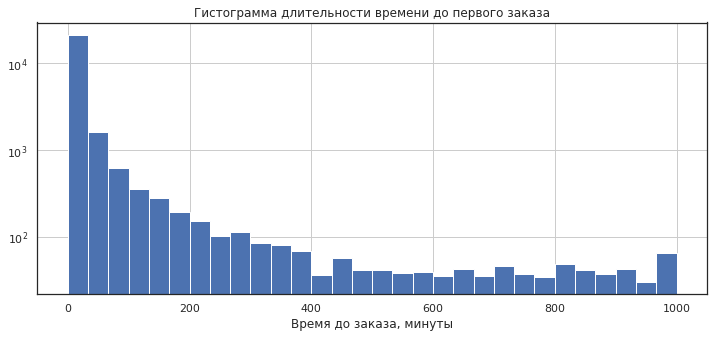

In [41]:
visit_first_buy2.query("ts_minutes_to_buy < 1000").hist(bins=30,figsize=(12, 5),range=(0,1000));
plt.title('Гистограмма длительности времени до первого заказа')
plt.yscale('log')
plt.xlabel('Время до заказа, минуты')

Больше всего покупок совершается в первые часы с момента перого визита.

In [42]:
# вычисляем время первой сессии + время первого заказа, объединяем по uid и вычисляем разницу во времени
# в минутах - dt.total_seconds() возвращает секунды, делим на 60
viz_duration = orders.groupby('uid').agg({'buy_ts': 'min'})\
    .rename(columns={'buy_ts': 'first_buy_ts'})\
    .join(
        visits.groupby('uid').agg({'start_ts': 'min'})\
            .rename(columns={'start_ts': 'first_session_ts'})
    )\
    .assign(ts_minutes_to_buy = lambda row: (row['first_buy_ts'] - row['first_session_ts']).dt.total_seconds()/60)

In [43]:
# посмотрим на описательные статистики
viz_duration['ts_minutes_to_buy'].describe([0.75, 0.85, 0.9, 0.95])

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
50%          16.000000
75%        2897.000000
85%       31755.500000
90%       83633.000000
95%      178408.000000
max      523144.000000
Name: ts_minutes_to_buy, dtype: float64

Видим, что стандартное отклонение в несколько раз выше среднего, значит есть много выбросов, попробуем построить диаграмму размаха, не отображая выбросы

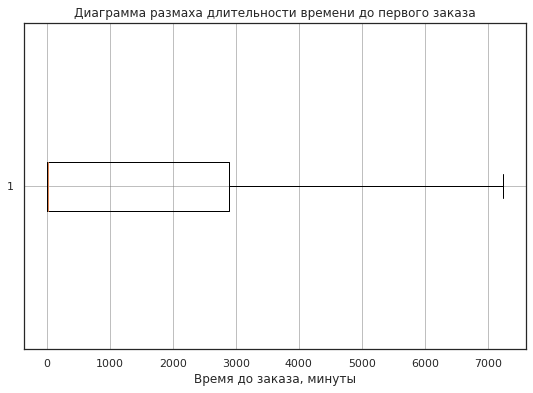

In [44]:
plt.figure(figsize=(9, 6))
plt.title('Диаграмма размаха длительности времени до первого заказа')
plt.boxplot(viz_duration['ts_minutes_to_buy'], showfliers=False, vert=False)
#plt.xscale('log')
plt.xlabel('Время до заказа, минуты')
plt.grid(True, color='grey', linewidth=0.5)
plt.show()

Все равно видим, что есть большие значения, медиана прилипшая к 0, попробуем ограничить сильнее диапазон значений и построить гистограмму

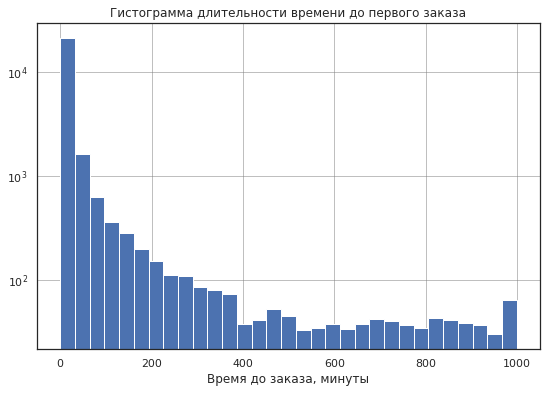

In [45]:
plt.figure(figsize=(9, 6))
plt.title('Гистограмма длительности времени до первого заказа')
plt.hist(viz_duration.query("ts_minutes_to_buy < 1000")['ts_minutes_to_buy'], bins=31)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Время до заказа, минуты')
plt.grid(True, color='grey', linewidth=0.5)
plt.show()

<b> Сколько раз покупают за период? <a name="p2_2_2"></a>

In [46]:
(orders.groupby(['uid'])['buy_ts'].count().reset_index())['buy_ts'].mean()

1.3803630588943954

В среднем один пользователь совершает 1,38 покупок на сайте за год.

In [47]:
monthly = orders.groupby(['uid','month'])['buy_ts'].count().reset_index()
monthly.groupby(['month'])['buy_ts'].mean()

month
1     1.211134
2     1.240254
3     1.273858
4     1.192784
5     1.226298
6     1.163538
7     1.191028
8     1.227582
9     1.231636
10    1.214759
11    1.244557
12    1.258195
Name: buy_ts, dtype: float64

Если разбить покупки по месяцам, то самый высокий средний показатель покупок наблюдается в феврале, ноябре и декабре. 

<b> Какой средний чек? <a name="p2_2_3"></a>

In [48]:
orders['revenue'].mean()

4.999646930477041

Средняя выручка по выборке составила 4,99. Это в какой валюте интересно?

Разобьем ее по месяцам.

In [49]:
orders.groupby(['month'])['revenue'].mean()

month
1     4.112927
2     4.840095
3     5.413930
4     5.150645
5     4.771279
6     4.059834
7     5.306589
8     4.847139
9     5.416448
10    4.928280
11    4.783518
12    5.852139
Name: revenue, dtype: float64

Наблюдаем самый высокий средний чек в декабре.

<b> Сколько денег приносят? (LTV) <a name="p2_2_4"></a>

Добавим месяц первого заказа в датафрейм к заказам, сгруппируем зазазы в когорты, объединим cohorts и cohort_sizes.

In [50]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [51]:
orders_first_month = pd.merge(orders,first_orders, on='uid') 
cohorts = orders_first_month.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index() 
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92
77,2018-05-01,2988,2018-05-01,13925.76


Посчитаем валовую прибыль. предположим, что маржинальность в Яндекс.Афише = 100%, поэтому она фактически будет равна столбцу `revenue`. Посчитаем возраст когорт и их LTV.

In [52]:
margin_rate = 1 
report['gp'] =  report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']
report

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531
...,...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0,4.657597
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1,0.531599
77,2018-05-01,2988,2018-05-01,13925.76,13925.76,0,4.660562


Создадим сводную таблицу для наглядности.

In [53]:
result = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(3)
result

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724,0.485,0.438,0.955,1.023,0.736,0.950,0.582,0.553,0.606,0.571,0.257
2017-07-01,6.010,0.335,0.624,0.359,0.177,0.156,0.120,0.142,0.161,0.147,0.156,NaN
2017-08-01,5.277,0.472,0.458,0.391,0.494,0.284,0.211,0.405,0.292,0.188,NaN,NaN
2017-09-01,5.645,1.118,0.521,3.976,0.401,0.647,0.702,0.243,0.184,NaN,NaN,NaN
2017-10-01,5.004,0.536,0.191,0.157,0.152,0.120,0.085,0.115,NaN,NaN,NaN,NaN
2017-11-01,5.155,0.399,0.200,0.325,0.148,0.054,0.115,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738,0.260,0.925,1.065,0.313,0.338,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.136,0.295,0.304,0.143,0.063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.157,0.278,0.079,0.074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видим, что жизненная ценность клиента кратно снижается со временем, но клиенты родолжают пользоваться услугами Яндекс.Афиши достаточно долгое время.

Просчитаем отдельно накопительную сумму и построим тепловую карту.

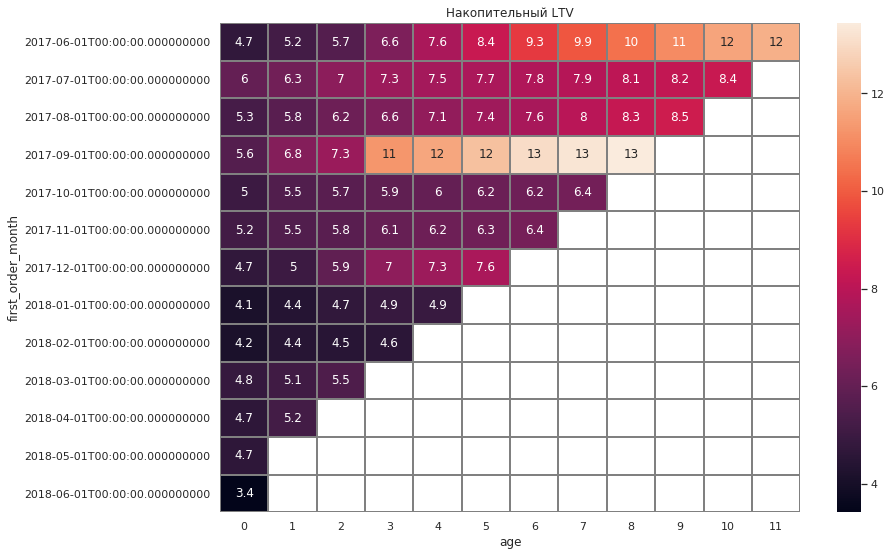

In [54]:
result2 = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(3).cumsum(axis=1).round(2)
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Накопительный LTV')
sns.heatmap(result2, annot=True, linewidths=1, linecolor='gray');

Больше всего выгоду компании принесла сентябрьская когорт клиентов, которая на 5й месяц принесла столько же, сколько первая (июньская когорта) за 10 месяцев. Начиная с Января когорты стали приносить меньше в сравнении с аналогичным сроком жизни когорт, прошедших ранее. Маркетологом нужно понять сезонные ли это изменения или они плохо стали работать.

<b> 2.3 Маркетинг <a name="p2_3"></a>

<b> Потрачено <a name="p2_3_1">

Всего потрачено на маркетинг.

In [55]:
costs['costs'].sum()

329131.62

Потрачено по источникам.

In [56]:
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
costs_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


Потрачено по месяцам.

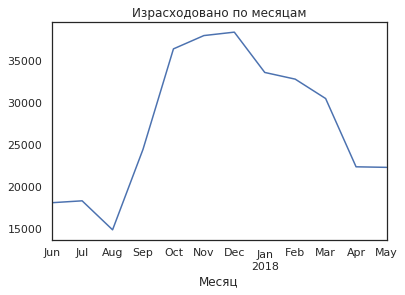

In [57]:
costs['cost_month'] = costs['dt'].astype('datetime64[M]')
cst_mon = costs.groupby('cost_month')['costs'].sum()
cst_mon.plot();
plt.title('Израсходовано по месяцам')
plt.xlabel('Месяц');

Самый затратный вид привлечения траффика скрывается по номером 3 и лидирует с большим отрывом.

Больше всего на рекламу тратилось в осенне-зимний период. 

Свяжем это с горядущими праздниками и повышенной активностью пользователей. А источник трафика предположительно - контекстная реклама.

In [58]:
costs_by_month_source = costs.pivot_table(index='cost_month', columns='source_id', values='costs', aggfunc='sum')

In [59]:
 costs_by_month_source_share = costs_by_month_source\
    .join(costs_by_month_source\
    .apply(lambda row: row.sum(), axis=1).to_frame(name='all'))\
    .apply(lambda row: row / row['all'], axis=1)\
    .drop('all', axis=1)

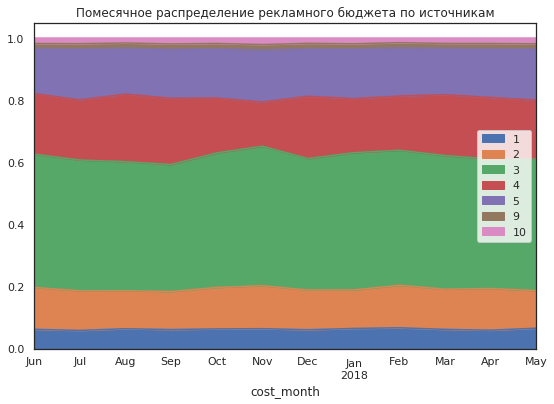

In [60]:
costs_by_month_source_share.plot(kind='area', figsize=(9, 6),
                                 title='Помесячное распределение рекламного бюджета по источникам')
plt.show()

<b> Сколько стоило привлечение одного покупателя из каждого источника? <a name="p2_3_2">


Для начала сгруппируем заказавших по источникам.

In [61]:
order_by_source = visit_first_buy.groupby('source_id').agg({'uid': 'nunique'}).reset_index()
order_by_source.columns = ['source_id', 'n_buyers']
order_by_source

,source_id,n_buyers
0,1,7138
1,2,7305
2,3,13846
3,4,14253
4,5,10156
5,7,1
6,9,2793
7,10,1773


Видим, что есть источник с id 7, на который средства не тратились. 

Соединим полученные таблицы и рассчитаем расходы на привлечение одного пользователя.

In [62]:
costs_per_user = pd.merge(costs_by_source,order_by_source, on='source_id') 
costs_per_user['per_user'] = costs_per_user['costs'] / costs_per_user['n_buyers'] 
costs_per_user

,source_id,costs,n_buyers,per_user
0,1,20833.27,7138,2.918642
1,2,42806.04,7305,5.859828
2,3,141321.63,13846,10.206676
3,4,61073.60,14253,4.284965
4,5,51757.10,10156,5.096209
5,9,5517.49,2793,1.975471
6,10,5822.49,1773,3.283976


Самоя дорогая стоимость привлечения у источника № 3. Но и количество привлеченных в нем значительно больше. Самыми привлекательными по цене на пользователя выглядят источники 1 и 9. Может стоить чуть перераспределить бюджеты?

<b> На сколько окупились расходы? (ROI)  <a name="p2_3_3">

Посчитаем помесячные расходы и добавим их в когортный отчет, созданный ранее.

In [63]:
monthly_costs = costs.groupby('cost_month').sum() 
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='cost_month')

Посчитаем CAC (стоимость привлечения клиента) и ROMI (коэффициент окупаемости).

In [64]:
report_new['cac'] = report_new['costs'] / report_new['n_buyers'] 
report_new['romi'] = report_new['ltv'] / report_new['cac']

Построим сводную таблицу и посчитаем накопительную сумму по когортам.

In [65]:
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2) 
output

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


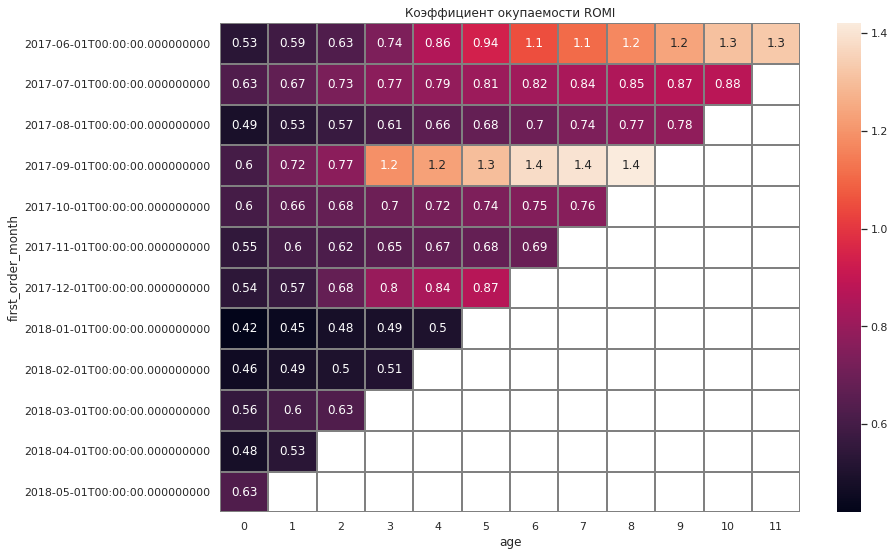

In [66]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Коэффициент окупаемости ROMI')
sns.heatmap(output, annot=True, linewidths=1, linecolor='gray');

Первая когорта окупилась на 6 месяце. Четвертая когорта (сентябрьская) - на третьем. Наш лидер по окупаемости.

Остальные когорты не окупились, но многие близки к этому. 

Также видим, что когорта за май 2018 повторила рекорд окупаемости от января 2017 в первый месяц привлечения. У нее есть хорошие шансы окупиться быстрее.

Узнаем, как быстро в среднем когорты окупаются. Усредним значения каждой колонки и «сложим» таблицу в единую строку методом mean(axis=0).

In [67]:
output.mean()

age
0     0.540833
1     0.582727
2     0.629000
3     0.717778
4     0.783750
5     0.860000
6     0.898333
7     0.970000
8     1.052500
9     0.963333
10    1.095000
11    1.330000
dtype: float64

В среднем, говорить об окупаемости можно только после 8ого месяца с момента привлечения клиента. Пока месть срок достаточно большой.

Посчитаем сводную таблицу с LTV и накопительный LTV за 6 месяцев после первой покупки.

In [68]:
final_result = report_new.pivot_table( index='first_order_month',
                                      columns='age', values='ltv', 
                                      aggfunc='mean')# посчитайте сводную таблицу с LTV

m6_cum_ltv = final_result.cumsum(axis=1).mean(axis=0)[5] 
m8_cum_ltv = final_result.cumsum(axis=1).mean(axis=0)[7] 

print('Средний LTV за 6 месяцев после первой покупки:', m6_cum_ltv)
print('Средний LTV за 8 месяцев после первой покупки:', m8_cum_ltv)

Средний LTV за 6 месяцев после первой покупки: 7.969052630207336
Средний LTV за 8 месяцев после первой покупки: 9.083582764260022


Чтобы вложения окупились за пол года, Яндекс.Афиша должна потратить на маркетинг меньше, чем 7,96 условных единиц.

<b>Метрики в разрезе источников  и устройств  <a name="p2_3_4">

Просчитаем отдельно.

In [69]:
# определяем источник пользователя
sources = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'})
# соединяем первые покупки и источники 
payers = orders.groupby('uid').agg({'buy_ts': 'min'}).merge(sources, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy_ts': 'first_buy'})
# считаем ltv
ltv = payers.merge(orders, on = 'uid')
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_buy']) / np.timedelta64(1,'M')).round().astype(int)
ltv = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
ltv = ltv.cumsum(axis = 1)
# добавляем размеры когорт и делим на них
cohort_sizes = payers.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})
ltv = ltv.merge(cohort_sizes, on = 'source_id')
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = 'cohort_size')
ltv

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,6.156185,7.150835,7.891156,8.537754,9.029303,9.251083,9.525826,9.866858,10.191256,10.450862,10.557561,10.673508,10.724577
2,6.770593,8.054740,9.717921,11.253637,11.900125,12.484390,12.721418,12.948380,13.171358,13.233560,13.346994,13.380422,13.383802
3,4.477694,4.729283,4.865748,5.008149,5.083093,5.122590,5.147003,5.173669,5.192354,5.197477,5.202699,5.203834,5.204931
4,4.584762,4.738128,4.852278,4.948617,5.068362,5.226563,5.342363,5.391025,5.410340,5.448244,5.502627,5.505380,5.506685
5,4.909883,5.114191,5.469974,6.836748,7.072747,7.246335,7.365203,7.454998,7.515129,7.576270,7.582746,7.592303,7.592558
7,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000
9,3.880901,4.167390,4.408024,4.678888,4.788189,4.935588,5.059127,5.126608,5.244430,5.284972,5.293566,5.293566,5.293566
10,3.164131,3.227434,3.254695,3.302558,3.316576,3.319217,3.332724,3.343348,3.346102,3.348631,3.348631,3.348631,3.348631


Жизненная ценность в разрезе источников возрастает со временем. Топами по накопительному доходу являются источники 1 и 2.

Найдем LTV в разрезе устройств.

In [70]:
# определяем устройство пользователя
device = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'device': 'first'})
# соединяем первые покупки и устройство 
payers = orders.groupby('uid').agg({'buy_ts': 'min'}).merge(device, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy_ts': 'first_buy'})
# считаем ltv
ltv2 = payers.merge(orders, on = 'uid')
ltv2['lifetime'] = ((ltv2['buy_ts'] - ltv2['first_buy']) / np.timedelta64(1,'M')).round().astype(int)
ltv2 = ltv2.pivot_table(index = 'device', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
ltv2 = ltv2.cumsum(axis = 1)
# добавляем размеры когорт и делим на них
cohort_sizes2 = payers.groupby('device').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})
ltv2 = ltv2.merge(cohort_sizes2, on = 'device')
ltv2 = ltv2.div(ltv2['cohort_size'], axis = 0).drop(columns = 'cohort_size')
ltv2

,0,1,2,3,4,5,6,7,8,9,10,11,12
device,,,,,,,,,,,,,
desktop,4.910144,5.299873,5.710589,6.363962,6.606369,6.782391,6.915505,7.018722,7.107014,7.167756,7.211931,7.229463,7.234596
touch,4.747406,5.024646,5.209044,5.275748,5.330682,5.461850,5.484181,5.519675,5.531470,5.546719,5.558411,5.564929,5.569944


In [71]:
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

Пользователи с ПК приносят больше денег в долгосрочной перспективе. Да и посещает сайт с ПК намного больше людей.

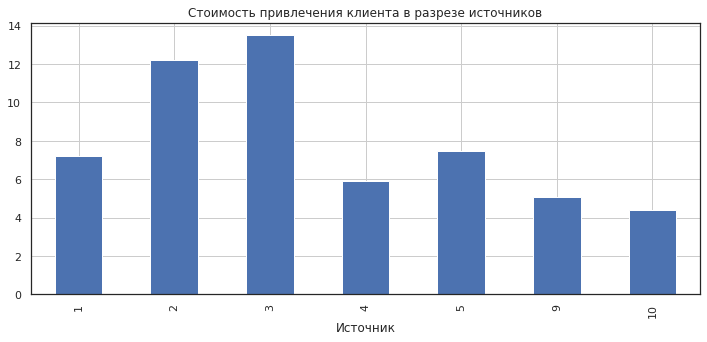

In [72]:
# считаем САС
cac = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index().merge(cohort_sizes.reset_index(), left_on = 'source_id', right_on='source_id')
cac['cac'] = cac['costs'] / cac['cohort_size']
cac = cac.set_index('source_id')
cac['cac'].plot(kind='bar', grid=True, figsize=(12, 5), title='Стоимость привлечения клиента в разрезе источников');
plt.xlabel('Источник');

 Самый дорогой источник - источник 3. 

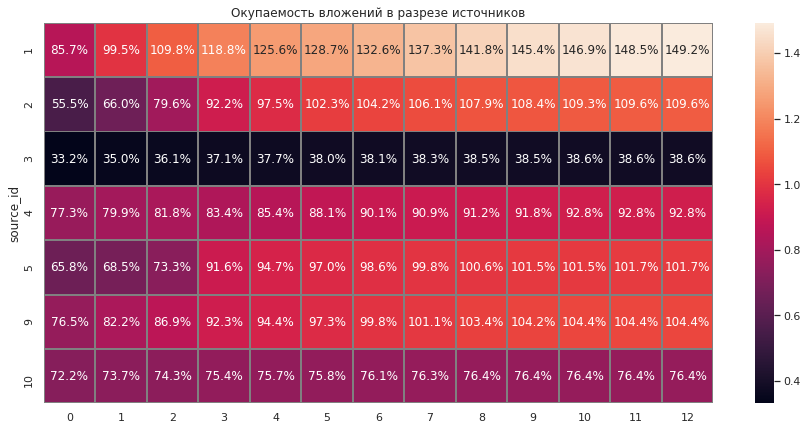

In [73]:
# считаем ROMI
romi = ltv.merge(cac[['cac']], on = 'source_id')
romi = romi.div(romi['cac'], axis = 0).drop(columns = 'cac')

sns.set(style='white')
plt.figure(figsize=(15, 7))
plt.title('Окупаемость вложений в разрезе источников')
plt.xlabel('Время жизни');
plt.ylabel('Источник');
sns.heatmap(romi, annot=True,  fmt='.1%', linewidths=1, linecolor='gray');

Явный аутсайдер виден сразу - источник 3. Нужно что-то делать, либо снижать стоимость привлечениея клиента, либо перераспределеять расходы.
Источник 1 явный лидер. Нужно уделить ему больше внимания и бюджета. 
Источники 2, 5, 9 показывают хороший уровень.

<b> Шаг 3. Общий вывод <a name="p3"></a>

В ходе исследования бизнес-показателей Яндекс.Афиши за период с июня 2017 по конец мая 2018 года можно отметить следующее:
    - в среднем на сайт в день заходит 908 уникальных пользователей, в месяц - 23228;
    - самый высокий Retention Rate первой недели отмечен в первой когорте пользователей - 9,2 %. В дальнейшем он варьируется по когортам с течением времени от 2,7 до 5,7 % и убывает начиная со 2 недели. В целом, можно отметить очень низкий коэффициент возврата пользователей и низкий коэффициент их удержания. Только 22,8 % пользователей возвращаются на сайт. Есть над чем работать;
    - в среднем с момента первого визита до заказа проходит 1 день 16 часов;
    - в среднем один пользователь совершает 1,38 покупок на сайте за год;
    - средняя выручка с покупке по выборке составила 4,99, лидирует по выручке декабрь;
    - чтобы вложения окупились за пол года, Яндекс.Афиша должна потратить на маркетинг меньше, чем 7,96 условных единиц; 
    - пользователи с ПК приносят больше денег в долгосрочной перспективе. Да и посещает сайт с ПК намного больше людей.

На графиках продемонстрировано, что покупки на сайте проседают летом и достигают пиковых значений к новому году и весной. Это можно связать с подготовкой к праздникам и поиском отличных подарков. Плюс летом люди менее заинтересованы в посещении развлекательных мероприятий.

С графиком помесячных покупок коррелируют и затраты на рекламу, которые возрастают в осенне-зимний период и проседают летом.
Самый затратный вид привлечения траффика скрывается по номером 3 и лидирует с большим отрывом. Предположим, что это контекстная реклама.

Расчёт LTV показал, что жизненная ценность клиента кратно снижается со временем, но клиенты родолжают пользоваться услугами Яндекс.Афиши достаточно долгое время. Это можно объяснить предположением, что люди не посещают события регулярно, а покупают билеты о случая к случаю себе или в подарок. Можно рассмотреть выделение отдельного бюджета отделу маркетинга на увеличение LTV, специальные акции или партнерские скидки после совершения первой покупки и регулярные напоминания о них.


Говорить об окупаемости затрат можно только после 8ого месяца с момента привлечения клиента. Пока месть срок достаточно большой, нужно попытаться его сократить увеличением числа повторных покупок и возвращений на сайт.

Самая дорогая стоимость привлечения у источника № 3. Но и количество привлеченных в нем значительно больше. Самыми привлекательными по цене на пользователя выглядят источники 1 и 9. 

Анализ ROMI по источникам показал, что жизненная ценность в разрезе источников возрастает со временем, что логично. Топами по накопительному доходу являются источники 1 и 2. Нужно уделить им больше внимания и бюджета. Источники 5, 9 показывают хороший уровень. Поскольку возврат средств имеет самые плохие показатели в источнике 3 нужно пересмотреть его бюджет: либо снижать стоимость привлечения клиента, либо перераспределять расходы, на более выгодные варианты.
